# Movie Review Sentiment
This notebook describes Anne and Casey's first attempt at building models for [Kaggle Movie Review Sentiment](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews).  We decided that for a first iteration, we would try a lot of different models based on research that we had done, learning as much as we could while seeing what would work the best.

The sections are:
- Naive Bayes Classifier
    - implemented by hand
    - using sklearn MultinomialNB
    - using NLTK
- sklearn Pipeline with a variety of estimators
- Using Logistic Regression


In [1]:
import numpy as np 
import pandas 

data = pandas.read_csv('train.tsv', sep = '\t') 
testdata = pandas.read_csv('test.tsv', sep = '\t') 

In [2]:
def make_submission(predictions, filename):
    # Create a new dataframe with only the columns Kaggle wants from the dataset.
    submission = pandas.DataFrame({
            "PhraseId": testdata["PhraseId"],
            "Sentiment": predictions
        })
    submission.to_csv(filename, index=False)

## Naive Bayes Classifier
### Implemented by Hand
The purpose of this section is to work through the [DataQuest Naive Bayes Tutorial](https://www.dataquest.io/blog/naive-bayes-movies/) to learn to how implement a simple version of the Naive Bayes algorithm.  The tutorial assumes the dataset has only 3 categories: 0 for neutral, 1 for positive, and -1 for negative.  It will take a bit of adaptation to make it work for the 5 categories we have.

In [2]:
# A nice python class that lets you count how many times items occur in a list
from collections import Counter
import string

# returns a string of all sentences with given sentiment score
def get_text(data,score):
#     given_score = data.Phrase[data.Sentiment == score]
#     return " ".join([phrase.lower() for phrase in given_score])
    phrases = data.Phrase[data.Sentiment == score]
    return " ".join(phrases)

# returns a counter object for a string of word counts
# removes punctuation and empty strings, lowercases
def count_text(text):
    words = text.split()
    actual_words = []
    for w in words:
        modified_word = w.lower().strip('.,;!?"()')
        if not modified_word.strip(string.ascii_letters) and modified_word != "":
            actual_words.append(modified_word)
    return Counter(actual_words)

These two functions allow us to extract some features from each phrase in the data.  The get_text function takes the data and extracts all full sentences with a particular score.  It only does full sentences so that the word counts are not skewed by the constant repetitions of the phrases as they get broken down.  It returns these joined together as a single string.

Then, count_text takes this string and splits it into individual words.  It lowercases them and strips them of punctuation, then uses the Counter object to get a frequency count for each word.  This allows us to know how many times a certain word appears in all the reviews of a certain sentiment

In [3]:
very_negative_text = get_text(data, 0)
negative_text = get_text(data, 1)
neutral_text = get_text(data, 2)
positive_text = get_text(data, 3)
very_positive_text = get_text(data, 4)

# Generate word counts for each tone.
very_negative_wordcounts = count_text(very_negative_text)
negative_wordcounts = count_text(negative_text)
neutral_wordcounts = count_text(neutral_text)
positive_wordcounts = count_text(positive_text)
very_positive_wordcounts = count_text(very_positive_text)

print "Negative text sample:", very_negative_text[:300]
print negative_wordcounts

Negative text sample: would have a hard time sitting through this one have a hard time sitting through this one Aggressive self-glorification and a manipulative whitewash self-glorification and a manipulative whitewash Trouble Every Day is a plodding mess . is a plodding mess plodding mess could hate it for the same reas
Counter({'the': 10745, 'a': 7776, 'of': 6562, 'and': 6101, 'to': 5467, 'is': 3351, 'it': 3050, 'that': 2976, 'in': 2907, 'as': 2166, 'for': 1708, 'its': 1631, 'with': 1533, 'movie': 1379, 'but': 1303, 'an': 1296, 'film': 1271, 'be': 1249, 'this': 1244, 'not': 1124, 'on': 1109, 'too': 1102, 'more': 1024, 'by': 1010, 'you': 956, 'or': 950, 'like': 913, 'than': 901, 'have': 871, 'from': 818, 'at': 787, 'are': 758, 'so': 728, 'about': 726, 'all': 724, 'one': 720, 'no': 714, 'his': 699, 'has': 661, 'out': 617, 'just': 597, 'much': 594, 'does': 566, 'story': 528, 'up': 524, 'into': 517, 'little': 490, 'if': 477, 'who': 466, 'been': 465, 'characters': 455, 'bad': 427, 'can': 

This section creates some variables to the hold the texts and wordcount dictionaries for each of the possible sentiment scores

In [52]:
def get_count_for_score(score, data):
    return len(data.Phrase[data.Sentiment == score])

# We need these counts to use for smoothing when computing the prediction.
very_negative_count = get_count_for_score(0,data)
negative_count = get_count_for_score(1, data)
neutral_count = get_count_for_score(2, data)
positive_count = get_count_for_score(3, data)
very_positive_count = get_count_for_score(4, data)

num = float(len(data))
# These are the class probabilities (we saw them in the formula as P(y)).
prob_very_negative = very_negative_count / num
prob_negative = negative_count / num
prob_neutral = neutral_count / num
prob_positive = positive_count / num
prob_very_positive = very_positive_count / num

def make_class_prediction(text, wordcounts, class_prob, class_count):
    prediction = 1
    text_counts = count_text(text)
    for word in text_counts:
        # For every word in the text, we get the number of times that word occured in the reviews for a given class, add 1 to smooth the value, and divide by the total number of words in the class (plus the class_count to also smooth the denominator).
        # Smoothing ensures that we don't multiply the prediction by 0 if the word didn't exist in the training data.
        # We also smooth the denominator counts to keep things even.        
        prediction *=  text_counts.get(word) * ((wordcounts.get(word, 0) + 1) / float(sum(wordcounts.values()) + class_count))
    # Now we multiply by the probability of the class existing in the documents.
    return prediction * class_prob

# As you can see, we can now generate probabilities for which class a given review is part of.
# The probabilities themselves aren't very useful -- we make our classification decision based on which value is greater.
print "Review:", data.Phrase[0], data.Sentiment[0]
print "Very Negative prediction:", make_class_prediction(data.Phrase[0], very_negative_wordcounts, prob_very_negative, very_negative_count)
print "Negative prediction:", make_class_prediction(data.Phrase[0], negative_wordcounts, prob_negative, negative_count)
print "Neutral prediction:", make_class_prediction(data.Phrase[0], neutral_wordcounts, prob_neutral, neutral_count)
print "Positive prediction:", make_class_prediction(data.Phrase[0], positive_wordcounts, prob_positive, positive_count)
print "Very Positive prediction:", make_class_prediction(data.Phrase[0], very_positive_wordcounts, prob_very_positive, very_positive_count)


Review: A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story . 1
Very Negative prediction: 3.67811909387e-78
Negative prediction: 2.0250170009e-77
Neutral prediction: 1.67847551086e-77
Positive prediction: 4.50313251885e-79
Very Positive prediction: 4.7036828234e-79


In [53]:
def make_decision(text):
    # Compute the negative and positive probabilities.
    predictions = [
        make_class_prediction(text, very_negative_wordcounts, prob_very_negative, very_negative_count),
        make_class_prediction(text, negative_wordcounts, prob_negative, negative_count),
        make_class_prediction(text, neutral_wordcounts, prob_neutral, neutral_count),
        make_class_prediction(text, positive_wordcounts, prob_positive, positive_count),
        make_class_prediction(text, very_positive_wordcounts, prob_very_positive, very_positive_count) ]
    return predictions.index(max(predictions))

make_decision(data.Phrase[0])

1

In [54]:
predictions = []
for phrase in testdata.Phrase:
    predictions.append(make_decision(phrase))

In [55]:
# Create a new dataframe with only the columns Kaggle wants from the dataset.
make_submission(predictions, "naivebayes_2.csv")

The first submssion scored scored **0.42851** on Kaggle, which is pretty disappointing because it's worse than the "Everything Neutral benchmark" at 0.51 - what you would score if you just guess everything as neutral.  I wonder if this is because I only accounted for sentences in the word frequency?  How would it change if I counted all phrases?

So, after going back and making the change where I account for ALL phrases when calculating word frequency (instead of just words in the full sentences), the model improved significantly!  We got **0.53901**, which is better than the Neutral Benchmark!

### Using sklearn Builtin Algorithms for Naive Bayes

In [56]:
import wordcloud

def make_word_cloud(feature_names, coefficients):
    """ Create a word cloud with the words given by feature_names
        and given coefficients. """
    cloud = wordcloud.WordCloud()
    cloud.generate_from_frequencies(zip(feature_names, coefficients))
    return cloud.to_image()

In [57]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

# Generate counts from text using a vectorizer.  There are other vectorizers available, and lots of options you can set.
# This performs our step of computing word counts.
vectorizer = CountVectorizer(stop_words='english')
train_features = vectorizer.fit_transform([r for r in data.Phrase])
test_features = vectorizer.transform([r for r in testdata.Phrase])

# Fit a naive bayes model to the training data.
# This will train the model using the word counts we computer, and the existing classifications in the training set.
nb = MultinomialNB()
nb.fit(train_features, [int(r) for r in data.Sentiment])

# Now we can use the model to predict classifications for our test features.
predictions = nb.predict(test_features)

make_submission(predictions, "sklearn_bayes_1.csv")

In [62]:
vectorizer.get_feature_names()[1000:2000]

[u'awakens',
 u'award',
 u'awarded',
 u'awards',
 u'aware',
 u'awareness',
 u'awash',
 u'away',
 u'awe',
 u'awed',
 u'awesome',
 u'awful',
 u'awfully',
 u'awfulness',
 u'awkward',
 u'awkwardly',
 u'awkwardness',
 u'awry',
 u'axel',
 u'ayala',
 u'ayatollah',
 u'ayres',
 u'ayurveda',
 u'ba',
 u'baaaaaaaaad',
 u'baader',
 u'babak',
 u'babbitt',
 u'babes',
 u'babies',
 u'baboon',
 u'baby',
 u'babysitter',
 u'backbone',
 u'backdrop',
 u'backdrops',
 u'backed',
 u'background',
 u'backgrounds',
 u'backhanded',
 u'backlash',
 u'backmasking',
 u'backseat',
 u'backstage',
 u'backward',
 u'backwater',
 u'backyard',
 u'bacon',
 u'bad',
 u'badder',
 u'badly',
 u'badness',
 u'baffle',
 u'baffled',
 u'baffling',
 u'bag',
 u'bagatelle',
 u'baggage',
 u'bags',
 u'bai',
 u'bailiwick',
 u'bailly',
 u'baio',
 u'baird',
 u'bait',
 u'baked',
 u'baker',
 u'balance',
 u'balanced',
 u'balances',
 u'balancing',
 u'bald',
 u'balding',
 u'bale',
 u'balk',
 u'balkans',
 u'ball',
 u'ballast',
 u'ballerina',
 u'ball

In [64]:
nb.coef_[2,:]

array([ -9.79604367,  -8.09831315,  -8.8346325 , ...,  -9.7219357 ,
       -10.41508288, -12.36099303])

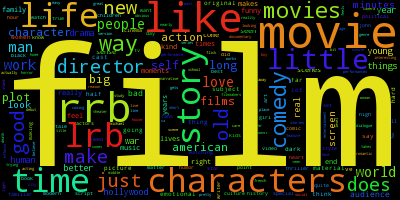

In [72]:
make_word_cloud(vectorizer.get_feature_names(), nb.coef_[2,:])

So after all that work making our by-hand naive bayes classifier, I followed the tutorial on how to use sk-learn to implement it.  The by-hand code takes 5-10 minutes to run and gave us .53, this one finished in 20 seconds and gave us a kaggle score of **0.59267**.  Wow, that's a big improvement.  But it was definitely nice to go through and see how the algorithm actually works behind the scenes, because it made a lot of sense separated out like that

### NLTK Builtin Naive Bayes
The previous code was all based on the DataQuest tutorial.  Now, I found a [different tutorial](http://streamhacker.com/2010/05/10/text-classification-sentiment-analysis-naive-bayes-classifier/) that works with the builtin Naive Bayes classifier in NLTK instead.  Again, since it's working with the NLTK movie corpus instead of our data, there will have to be adjustments to make it fit in five categories instead of two.

In [16]:
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
import string
 
# bag of words feature extraction
def word_feats(phrase):
    actual_words = []
    words = phrase.split()
    d = {}
    for w in words:
        modified_word = w.lower().strip('.,;!?"()')
        if not modified_word.strip(string.ascii_letters) and modified_word != "":
            if w not in d:
                d[w] = 1
            else:
                d[w] +=1
    return d

very_neg = data.Phrase[data.Sentiment == 0]
neg = data.Phrase[data.Sentiment == 1]
neutral = data.Phrase[data.Sentiment == 2]
pos = data.Phrase[data.Sentiment == 3]
very_pos = data.Phrase[data.Sentiment == 4]

very_neg_feats = [(word_feats(phrase),0) for phrase in very_neg]
neg_feats = [(word_feats(phrase),1) for phrase in neg]
neutral_feats = [(word_feats(phrase),2) for phrase in neutral]
pos_feats = [(word_feats(phrase),3) for phrase in pos]
very_pos_feats = [(word_feats(phrase),4) for phrase in very_pos]
 
print very_neg_feats

verynegcutoff = len(very_neg_feats)*3/4
negcutoff = len(neg_feats)*3/4
neutralcutoff = len(neutral_feats)*3/4
poscutoff = len(pos_feats)*3/4
veryposcutoff = len(very_pos_feats)*3/4

trainfeats = very_neg_feats[:verynegcutoff] + neg_feats[:negcutoff] + neutral_feats[:neutralcutoff] + pos_feats[:poscutoff] + very_pos_feats[:veryposcutoff]
testfeats = very_neg_feats[verynegcutoff:] + neg_feats[negcutoff:] + neutral_feats[neutralcutoff:] + pos_feats[poscutoff:] + very_pos_feats[veryposcutoff:]
print 'train on %d instances, test on %d instances' % (len(trainfeats), len(testfeats))
 
classifier = NaiveBayesClassifier.train(trainfeats)
print 'accuracy:', nltk.classify.util.accuracy(classifier, testfeats)
classifier.show_most_informative_features()

[({'a': 1, 'would': 1, 'sitting': 1, 'this': 1, 'hard': 1, 'one': 1, 'through': 1, 'have': 1, 'time': 1}, 0), ({'a': 1, 'sitting': 1, 'this': 1, 'hard': 1, 'one': 1, 'through': 1, 'have': 1, 'time': 1}, 0), ({'and': 1, 'a': 1, 'Aggressive': 1, 'manipulative': 1, 'whitewash': 1}, 0), ({'and': 1, 'a': 1, 'manipulative': 1, 'whitewash': 1}, 0), ({'a': 1, 'mess': 1, 'is': 1, 'plodding': 1, 'Every': 1, 'Trouble': 1, 'Day': 1}, 0), ({'a': 1, 'mess': 1, 'is': 1, 'plodding': 1}, 0), ({'mess': 1, 'plodding': 1}, 0), ({'for': 1, 'could': 1, 'it': 1, 'same': 1, 'reason': 1, 'the': 1, 'hate': 1}, 0), ({'hate': 1, 'it': 1}, 0), ({'hate': 1}, 0), ({'and': 1, 'flick': 1, 'just': 1, 'is': 1, 'proves': 1, 'in': 1, 'dream': 1, 'should': 1, 'to': 1, 'realization': 1, 'be': 1, 'his': 1, 'that': 2, 'dreams': 1, 'a': 1, 'of': 2, 'sometimes': 1, 'youth': 1, 'remain': 1, 'the': 1, 'Oedekerk': 1, 'childhood': 1}, 0), ({'be': 1, 'to': 1, 'that': 1, 'mythic': 1, 'hard': 1, 'try': 1, 'movies': 1, 'baseball': 1, '

In [17]:
right = 0
for d,res in testfeats:
    if res == classifier.classify(d):
        right+=1
print right / float(len(testfeats))

0.335520414178


It's not terribly accurate, but we might as well make a model with all the training data, and submit the test data to Kaggle and see what happens.

In [19]:
classifier_alltrain = NaiveBayesClassifier.train(very_neg_feats + neg_feats + neutral_feats + pos_feats + very_pos_feats)

pred= []
for phrase in testdata.Phrase:
    pred.append(classifier_alltrain.classify(word_feats(phrase)))
    
make_submission(pred, "nltk_bayes_1.csv")

Not unexpectedly, we didn't do great submitting this to Kaggle: **0.38863**.  The sklearn model did significantly better

## Trying sklearn Pipeline

We found out about sklearn's Pipeline feature, which allows you to string together ways to extract features and estimate your model, and decided we wanted to try different pipelines and add features and see where it could take us.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# create a pipeline of transforms and an estimator
def scikit_learn(train_set, train_labels):
    pipeline1 = Pipeline([('vect', CountVectorizer()),
         ('tfidf', TfidfTransformer()),
         ('clf', OneVsOneClassifier(LinearSVC())),
         ])
    
    pipeline2 = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier()),
        ])
    
    pipeline3 = Pipeline([('vect', CountVectorizer()),
         ('tfidf', TfidfTransformer()),
         ('clf', OneVsRestClassifier(LinearSVC())),
         ])
    
    pipeline4 = Pipeline([('vect', CountVectorizer()),
         ('tfidf', TfidfTransformer()),
         ('clf', MultinomialNB()),
         ])
    
    pipeline5 = Pipeline([('vect', CountVectorizer()),
         ('clf', MultinomialNB()),
         ])
    
    pipeline6 = Pipeline([('vect', CountVectorizer()),
         ('clf', OneVsOneClassifier(LinearSVC())),
         ])
    
    pipeline7 = Pipeline([('vect', CountVectorizer()),
         ('clf', OneVsRestClassifier(LinearSVC())),
         ])
    
    pipeline8 = Pipeline([('vect', CountVectorizer()),
         ('tfidf', TfidfTransformer()),
         ('clf', OneVsOneClassifier(LogisticRegression())),
         ])
    
    # don't run pipeline 9
    # for some reason it took hours and I eventually killed it
    pipeline9 = Pipeline([('vect', CountVectorizer()),
         ('tfidf', TfidfTransformer()),
         ('clf', OneVsOneClassifier(SVC(C=1, kernel='linear'))),
         ])

    X_train = np.asarray(train_set)
    text_clf = pipeline8.fit(X_train, np.asarray(train_labels))
    return text_clf

# make prediction
alg = scikit_learn(data.Phrase, data.Sentiment)
predicted = alg.predict(testdata.Phrase)
make_submission(predicted, "pipeline_8.csv")

`pipeline1`, which came from [this github source](https://github.com/yogesh-kamble/kaggle-submission/blob/master/movie_review.py) scored **0.62935** on Kaggle

`pipeline2`, which came from [this sample sklearn code](http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html) scored **0.55996**

`pipeline3` came from some research on OneVsOneClassifier and finding out there is also a OneVsRestClassifier, and testing that out.  It scored **0.61964**

`pipeline4` came from the previous code working with the DataQuest tutorial and the sklearn builtins for Naive Bayes.  We wanted to see how it might perform in the pipeline with additional transforms like tf-idf.  It scored **0.58289**, which is worse than the Naive Bayes dataquest code.

`pipeline5` is the same steps we took in the sklearn Naive Bayes from DataQuest (no tf-idf) because I wondered it would be the same, and if Pipeline was just doing the same steps that we had done by hand above.  It scored **0.59882**.  This is super interesting because the DataQuest code scored 0.592, and also just used CountVectorizer and MultinomialNB.  I wonder what Pipeline does that's different and gave it the extra score?

`pipeline6` is the same as `pipeline1` without the tf-idf transform.  If removing that step made the MultinomialNB pipeline better, maybe it will also improve this one.  It scored **0.61839**, which is interesting because it's slightly less than `pipeline1`'s score - clearly the tf-idf step helps when doing OneVsOne and LinearSVC, but hurts when doing MultinomialNB.  Why?

`pipeline7` is analogous to `pipeline6` - it tests the removal of the tf-idf step for the OneVsRestClassifier.  It scored **0.60384**.  Again, slightly less than when it included tf-idf.

`pipeline8` is because we wanted to try something other than LinearSVC in our classifier to see how that would affect it.  We tried LogisiticRegression and it scored **0.61241** - slightly worse than LinearSVC.

`pipeline9` uses a kernel=linear SVC instead of LinearSVC.  According to sklearn docs for LinearSVC: "Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples."  This scored ????? because IT TAKES AGES TO RUN

## Using Logistic Regression to train a model.
Inspiration was pulled from this article: https://jessesw.com/NLP-Movie-Reviews/ Logistic Regression is a scikit learn model, documentation for scikit learn can be found here: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

First, clean the data by sending the word to lowercase, remoing all punctuation marks, and spliting the words at every space. 

In [5]:
def cleanData(text):
    punctuation = {".", "/", "\\", ","}
    frequencyTracker = {}; 
    for mark in punctuation: 
        text = text.lower().replace(mark, " ")
    return text.lower().split()

In [6]:
#acqure all of the 'true' data, place all the data known to be true into array y_train
y_train = data['Sentiment']

In [7]:
#calls the clean data function for both the training and test data. Then appends the cleaned data to array train and test data, respectively.
training = []
for word in data['Phrase']: 
    training.append(" ".join(cleanData(word)))
testing = []
for otherword in testdata['Phrase']: 
    testing.append(" ".join(cleanData(otherword)))

Next we will use sklearn's TFIV library to vectorize the data and explore how often and how important a certain word occurs and is in the data set. This vectorization function that will later help determine which words are in positive reviews and which words are in negative reviews. Here is the documentation for the TFIV sklearn class: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html 

As you can see from the documentation, the parameters involved are: 
"min-df": this ignores the frequency of words less than a specific threshold value. 
"max_features": If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.
"strip accents": removes any ascii or unicode characters that are not words. 
"analyzer": could be either words or characters to analyze
"token pattern": Regex denoting what constitutes a token or whateever as defined by analyzer"
"ngram_range": the lower and upper boundary for n gram parsing. An n gram is essentially spliting up the sentence into length n and making a model with these different data sets. iNstead of analyzing and training on each word or entire sentence it can be broken down into n grams. More info here: http://www.text-analytics101.com/2014/11/what-are-n-grams.html 
"use_idf": this allows the inverse document frequency to reweight itself. default is set to true. 
"smooth_idf": increases the document count for each word so that each word is at least in one document. This prevents dividing by 0. 
"sublinear_tf": sublinear scaling. Instead of log, use 1 + log(tf)
"stop_words": words that were ignored because of their low frequency count, exceeded maximum counts, or occured in too few documents.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer as TFIV

tfv = TFIV(min_df=3,  max_features=None, 
        strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
        ngram_range=(1, 2), use_idf=1,smooth_idf=1,sublinear_tf=1,
        stop_words = 'english')

Then we will combine the train data and the test data in order to vectorize the data. After the tfv fits the data, then it transforms the documents into a document-terms matrix. Then seperates the data back into training set and testing set in order to continue with the process. The tfv transform returns a sparse matrix.
Finally, then we are ready and able to use Logistic Regression on the vectorized document-term matrix.

In [9]:
X_all = training + testing # Combine both to fit the TFIDF vectorization.
lentrain = len(training)

tfv.fit(X_all) 
X_all = tfv.transform(X_all)

X = X_all[:lentrain] # Separate back into training and test sets. 
X_test = X_all[lentrain:]

In [10]:
print X.shape
print y_train.shape

(156060, 89472)
(156060,)


We can see above that the shape of X, the sparse matrix, has more rows than columns.

We can see above that y_train is a 1D array of sentiment values.

Parameters from scikit learn's Logistic Regression: 
"C": This is an optional float where the value is the inverse of the regularization strength. What is regularization strength you ask? Well here is what the internet says regularization strength is: 
    Regularization is applying a penalty to increasing the magnitude of parameter values in order to reduce overfitting. When you train a model such as a logistic regression model, you are choosing parameters that give you the best fit to the data. This means minimizing the error between what the model predicts for your dependent variable given your data compared to what your dependent variable actually is.
    The problem comes when you have a lot of parameters (a lot of independent variables) but not too much data. In this case, the model will often tailor the parameter values to idiosyncrasies in your data -- which means it fits your data almost perfectly. However because those idiosyncrasies don't appear in future data you see, your model predicts poorly.
    
"dual": This is a boolean where it's false if the number of samples > number of features and true for the opposite. 
In our case, this should be set to false because samples > features 

"penalty": Either choice of L1 or L2. Apparently the L1 norm is not differentiable, therefore the L2 norm will leave the data looking smoother. 

"random-state": when shuffling the data, this value will be the seed if trying to recreate it. 

In [14]:
from sklearn.grid_search import GridSearchCV

grid_values = {'C':[30]} # this number is chosen for the reasoning above. More Cs!

log_reg = LogisticRegression(penalty = 'l2', dual = True, random_state = 0)

#Grid Search is an approximator for values that cannot be learned, but rather searches the space for the best fit. 
model_LR = GridSearchCV(log_reg, grid_values) 
#fit the model 
model_LR.fit(X, y_train) # Fit the model.

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1, param_grid={'C': [30]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [15]:
#mean scores, std, and params for all parameter combination of estimator functions
model_LR.grid_scores_

[mean: 0.53681, std: 0.00802, params: {'C': 30}]

In [16]:
#this is what the model predicts is the best estimator, this is like a line of best fit. 
#This is the estimator that gave the highest score in exhange for the smallest loss.
model_LR.best_estimator_

LogisticRegression(C=30, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
model_LR.

<bound method LogisticRegression.get_params of LogisticRegression(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)>

Once we have a model, now we can predict the results of the test, put the results in a csv, and submit to kaggle.

In [18]:
#use the model to precist the scores of the test data
#convert results to csv

LR_result = model_LR.predict(X_test) # We only need the probabilities that the movie review was a 7 or greater. 
LR_output = pandas.DataFrame(data={"PhraseId":testdata["PhraseId"], "Sentiment":LR_result}) # Create our dataframe that will be written.
LR_output.to_csv('Logistic_Reg_Proj2.csv', index=False, quoting=3) # Get the .csv file we will submit to Kaggle.

After uploading to kaggle, we discovered that the score was **0.58660**. This is interestingly low, but also close to our approximated, estimated mean. This was just an estimator model using linear regression on this estimation. We could have perhaps scored higher if we would have explored more with the scoring = 'roc_auc' attribute that belongs to GridSearchCV. This would just taken the area underneath the curve and perhaps provided a better approximation. 

In [19]:
log_reg

LogisticRegression(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)